In [1]:
# import essential libraries and functions
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tabulate import tabulate
import seaborn as sns
from numpy import asarray
from numpy import zeros

In [2]:
import keras
from keras.layers import LSTM,Embedding,Dense,Bidirectional,GlobalMaxPool2D,BatchNormalization,Dropout,TimeDistributed,GlobalMaxPool1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential,Model
from tensorflow.keras import layers
from keras.layers import SpatialDropout1D,GRU
from keras.layers import Conv1D, Flatten, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
import matplotlib.pyplot as plt
from keras_tuner.tuners import RandomSearch
from keras.layers import Conv1D

# Data Preprocessing

In [3]:
df = pd.read_csv("Dataset.csv", encoding='utf-8')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
# check for missing values
df.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

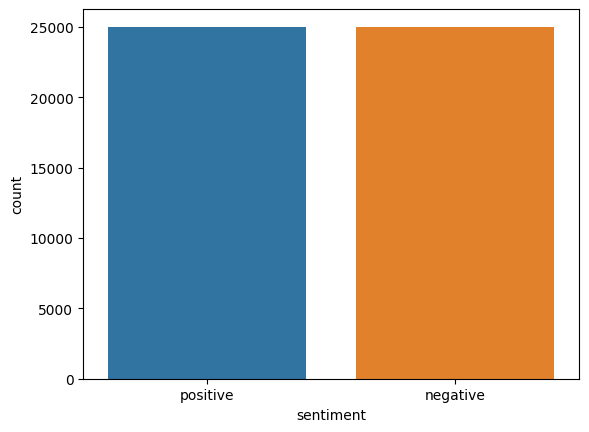

In [7]:
# check whether the dataset is balanced
sns.countplot(x='sentiment', data=df)

In [8]:
# clean text 
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text) # remove non-alphanumeric or non-whitespace characters
    text = text.lower() # lowercase the text
    text = re.sub('\[.*?\]', '', text) # remove square bracket info (square brackets themselves)
    text = re.sub('https?://\S+|www\.\S+', '', text) # remove URLs
    text = re.sub('<.*?>+', '', text) # remove HTML tags
    text = re.sub('\n', '', text) # remove newline characters
    text = re.sub('\w*\d\w*', '', text) # remove digits
    return text

In [9]:
# apply clean_text function
df['review'] = df['review'].apply(lambda x: clean_text(x))

In [10]:
# remove stop words 
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marce\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['review'] = df['review'].map(remove_stopwords)

In [12]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive


In [13]:
X = []
sentences = list(df['review'])
for sen in sentences:
    X.append(sen)

In [14]:
# replace labels with integers
y = df['sentiment'].replace({'negative': 0,'positive': 1})
y = np.array(list(y))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [17]:
vocab_length = len(word_tokenizer.word_index) + 1


In [18]:
vocab_length

154567

In [19]:
# pad all reviews to length 100
X_train = pad_sequences(X_train, padding='post', maxlen=100)
X_test = pad_sequences(X_test, padding='post', maxlen=100)

In [21]:
# create embeddings dictionary with GloVe word embeddings
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [22]:
# create Embedding Matrix having 100 columns 

embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [23]:
embedding_matrix.shape

(154567, 100)

In [24]:
# making the embedding layer
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=100 , trainable=False)

In [25]:
# check data 
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40000, 100)
(40000,)
(10000, 100)
(10000,)


# Modeling

In [26]:
# function constructs a neural network model with hyperparameters to be tuned. 
# the hyperparameters being tuned are the number of neurons in the first hidden layer (units) and the learning rate of the Adam optimizer
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_',
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [27]:
# define a tuner object for hyperparameter tuning using the Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='dir')

In [28]:
# summary of searching space
tuner.search_space_summary()

Search space summary
Default search space size: 2
units_ (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [29]:
# fit tuner
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 01m 31s]
val_accuracy: 0.5072999993960062

Best val_accuracy So Far: 0.5129999915758768
Total elapsed time: 00h 07m 28s


In [29]:
# results summary
tuner.results_summary()

Results summary
Results in dir\untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
units_: 416
learning_rate: 0.001
Score: 0.5086999932924906

Trial 3 summary
Hyperparameters:
units_: 448
learning_rate: 0.001
Score: 0.5077666640281677

Trial 0 summary
Hyperparameters:
units_: 512
learning_rate: 0.001
Score: 0.5076000094413757

Trial 2 summary
Hyperparameters:
units_: 192
learning_rate: 0.0001
Score: 0.5066666603088379

Trial 4 summary
Hyperparameters:
units_: 384
learning_rate: 0.01
Score: 0.5043666760126749


## SNN

In [30]:
# NN architecture

snn_model = Sequential()

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [31]:
# model compiling
snn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
print(snn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          15456700  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 15466701 (59.00 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 15456700 (58.96 MB)
_________________________________________________________________
None


In [32]:
# model training
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 4s 12ms/step - loss: 0.5608 - acc: 0.7101 - val_loss: 0.5139 - val_acc: 0.7577
Epoch 2/6
250/250 [==============================] - 2s 10ms/step - loss: 0.4511 - acc: 0.7946 - val_loss: 0.5017 - val_acc: 0.7621
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.4131 - acc: 0.8156 - val_loss: 0.5063 - val_acc: 0.7614
Epoch 4/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3880 - acc: 0.8268 - val_loss: 0.5200 - val_acc: 0.7564
Epoch 5/6
250/250 [==============================] - 2s 10ms/step - loss: 0.3741 - acc: 0.8334 - val_loss: 0.5284 - val_acc: 0.7595
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3596 - acc: 0.8430 - val_loss: 0.5418 - val_acc: 0.7556


In [33]:
# predictions on the Test Sep
score_snn = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 1s 4ms/step - loss: 0.5514 - acc: 0.7501


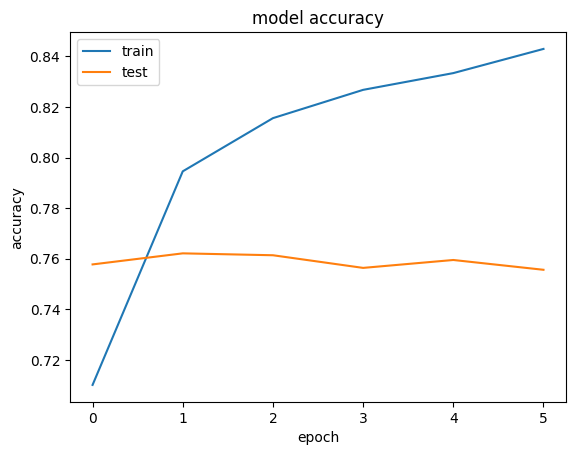

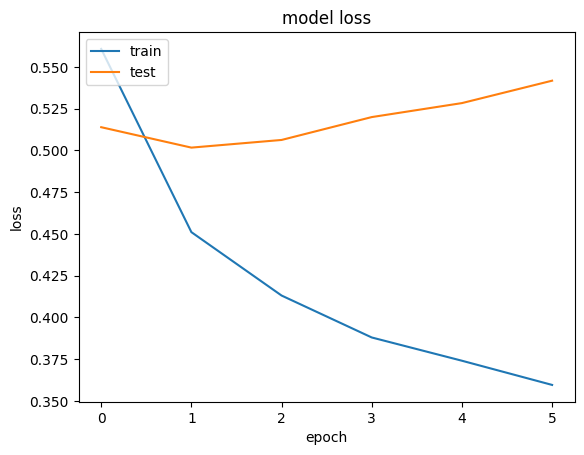

In [34]:
# model performance charts
plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## CNN

In [35]:
# NN architecture

cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=100 , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [36]:
# model compiling
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          15456700  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15520957 (59.21 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 15456700 (58.96 MB)
_________________________________________________________________
None


In [37]:
# model training
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 25s 95ms/step - loss: 0.4836 - acc: 0.7663 - val_loss: 0.3912 - val_acc: 0.8242
Epoch 2/6
250/250 [==============================] - 23s 94ms/step - loss: 0.3430 - acc: 0.8537 - val_loss: 0.3529 - val_acc: 0.8456
Epoch 3/6
250/250 [==============================] - 24s 94ms/step - loss: 0.2879 - acc: 0.8826 - val_loss: 0.3480 - val_acc: 0.8484
Epoch 4/6
250/250 [==============================] - 23s 94ms/step - loss: 0.2413 - acc: 0.9088 - val_loss: 0.3441 - val_acc: 0.8450
Epoch 5/6
250/250 [==============================] - 24s 95ms/step - loss: 0.1991 - acc: 0.9332 - val_loss: 0.3395 - val_acc: 0.8510
Epoch 6/6
250/250 [==============================] - 23s 94ms/step - loss: 0.1653 - acc: 0.9487 - val_loss: 0.3532 - val_acc: 0.8494


In [43]:
score_cnn = cnn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 4s 13ms/step - loss: 0.3541 - acc: 0.8475


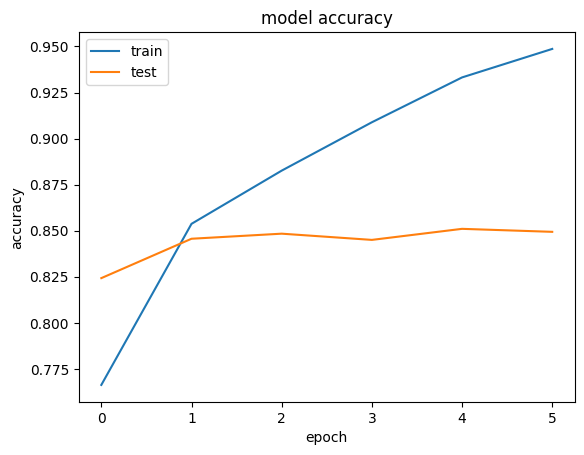

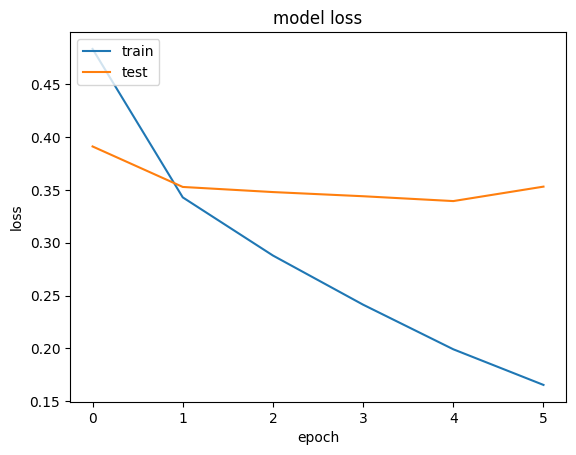

In [44]:
# model performance charts

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## LSTM

In [40]:
# NN architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=100 , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [41]:
# model compiling
lstm_model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          15456700  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15574077 (59.41 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 15456700 (58.96 MB)
_________________________________________________________________
None


In [42]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 93s 354ms/step - loss: 0.5282 - acc: 0.7476 - val_loss: 0.4418 - val_acc: 0.8020
Epoch 2/6
250/250 [==============================] - 90s 360ms/step - loss: 0.4264 - acc: 0.8070 - val_loss: 0.3949 - val_acc: 0.8241
Epoch 3/6
250/250 [==============================] - 94s 375ms/step - loss: 0.3846 - acc: 0.8298 - val_loss: 0.3668 - val_acc: 0.8394
Epoch 4/6
250/250 [==============================] - 91s 366ms/step - loss: 0.3555 - acc: 0.8467 - val_loss: 0.3386 - val_acc: 0.8565
Epoch 5/6
250/250 [==============================] - 94s 376ms/step - loss: 0.3295 - acc: 0.8621 - val_loss: 0.3386 - val_acc: 0.8556
Epoch 6/6
250/250 [==============================] - 92s 367ms/step - loss: 0.3141 - acc: 0.8697 - val_loss: 0.3720 - val_acc: 0.8556


In [45]:
score_lstm = lstm_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 21s 66ms/step - loss: 0.3681 - acc: 0.8564


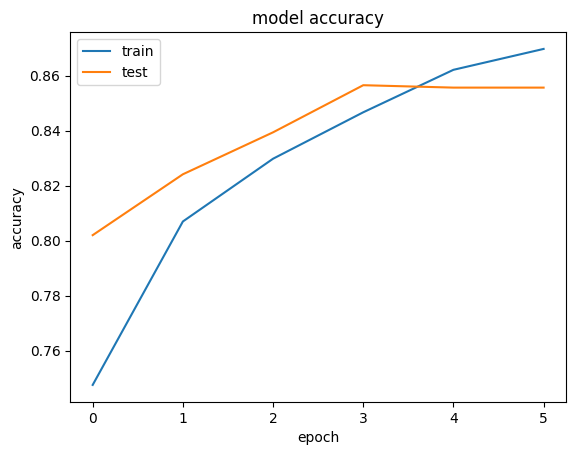

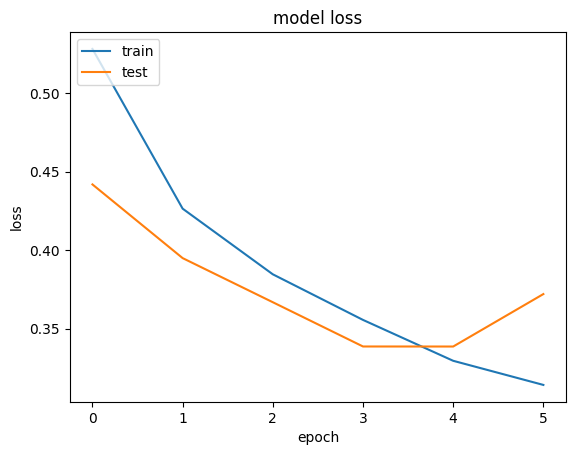

In [46]:
# model performance charts

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Results

In [47]:
data = [
    ["Loss", score_snn[0], score_cnn[0], score_lstm[0]],
    ["Test Accuracy", score_snn[1], score_cnn[1], score_lstm[1]]
]

headers = ["Metric", "Score_SNN", "Score_CNN", "Score_LSTM"]

print(tabulate(data, headers=headers, floatfmt=".2f"))

Metric           Score_SNN    Score_CNN    Score_LSTM
-------------  -----------  -----------  ------------
Loss                  0.55         0.35          0.37
Test Accuracy         0.75         0.85          0.86
